In [184]:
import os
import numpy as np
import pandas as pd
import seaborn as sns;sns.set()
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt
from matplotlib import cm
from pandas import read_csv, set_option
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer,RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing


from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import FastICA
from sklearn.manifold import Isomap
from sklearn.manifold import MDS
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection

# for dirname, _, filenames in os.walk('/kaggle/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
        
import time
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
%matplotlib inline

# time series cross validation
# https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/

''' FUNCTIONS '''

# One plot type
def plot_line(ldf,lst,title='',sec_id=None,size=[350,1000]):
    
    # sec_id - list of [False,False,True] values of when to activate supblots; same length as lst
    
    if(sec_id is not None):
        fig = make_subplots(specs=[[{"secondary_y": True}]])
    else:
        fig = go.Figure()
        
    if(len(lst) is not 1):
        ii=-1
        for i in lst:
            ii+=1
            if(sec_id is not None):
                fig.add_trace(go.Scatter(x=ldf.index, y=ldf[lst[ii]],mode='lines',name=lst[ii],line=dict(width=2.0)),secondary_y=sec_id[ii])
            else:
                fig.add_trace(go.Scatter(x=ldf.index, y=ldf[lst[ii]],mode='lines',name=lst[ii],line=dict(width=2.0)))
    else:
        fig.add_trace(go.Scatter(x=ldf.index, y=ldf[lst[0]],mode='lines',name=lst[0],line=dict(width=2.0)))

    fig.update_layout(height=size[0],width=size[1],template='plotly_white',title=title,
                          margin=dict(l=50,r=80,t=50,b=40));fig.show()
    
# plot n verticle subplots
def plot_vsubplots(lsubsubsubsubdf,lst,title='',nplots=None,lw_id=None,size=[400,1000]):

    # lw_id list of line widths if added
        
    assert(nplots is not None) 
    fig = make_subplots(rows=nplots,shared_xaxes=True)
    ii=-1
    for i in lst:
        ii+=1
        fig.add_trace(go.Scatter(x=ldf.index,y=ldf[lst[ii]], mode='lines',name=lst[ii],line=dict(width=lw_id[ii])), row=ii+1, col=1) 

    fig.update_layout(height=size[0],width=size[1],template='plotly_white',title=title,
                          margin=dict(l=50,r=80,t=50,b=40));fig.show()
    
colours = ['tab:blue','tab:red','tab:green']
def plot_line2(ldf,lst,title=''):
    
    ii=-1
    plt.figure(figsize=(14,5))
    for i in lst:
        ii+=1
        ax = ldf[lst[ii]].plot(color=colours[ii],label=lst[ii],lw=1.5)
    plt.title(title)
    plt.legend();plt.show()
    
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot Correlation to Target Variable only
def corrMat(df,target='demand',figsize=(9,0.5),ret_id=False):
    
    corr_mat = df.corr().round(2);shape = corr_mat.shape[0]
    corr_mat = corr_mat.transpose()
    corr = corr_mat.loc[:, df.columns == target].transpose().copy()
    
    if(ret_id is False):
        f, plt = plt.subplots(figsize=figsize)
        sns.heatmap(corr,vmin=-0.3,vmplt=0.3,center=0, 
                     cmap=cmap,square=False,lw=2,annot=True,cbar=False)
        plt.title(f'Feature Correlation to {target}')
    
    if(ret_id):
        return corr
    
def bar_plot(x, y,palette_len,title='Missing Values (%)', xlim = None, ylim = None, 
             xticklabels = None, yticklabels = None,xlabel = None, ylabel = None, 
             figsize = (10,4),pltis_grid = 'y'):
        
    cmap = sns.color_palette("plasma")
    fig, plt = plt.subplots(figsize = figsize)
    plt.title(title,size = 15, fontweight = 'bold')

    for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_color('black')
    
    ax.spines['top'].set_visible(True);ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False);plt.spines['left'].set_visible(False)

    sns.barplot(x = x, y = y, edgecolor = 'black', plt = plt,
                palette = cmap)
    plt.set_xlim(xlim);plt.set_ylim(ylim)    
    plt.set_xticklabels(xticklabels);plt.set_yticklabels(yticklabels)
    plt.xlabel(xlabel);plt.ylabel(ylabel)
    plt.grid(axis = axis_grid,ls='--',alpha = 0.9)
    plt.show()

# function to plot a two PCA Feature Plot using Pandas 
def scatterPlot(xDF, yDF, algoName):
    
    sns.set_style('whitegrid')
    fig, ax = plt.subplots()
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["Component 1","Component 2","Label"]
    g = sns.scatterplot(x="Component 1",y="Component 2",data=tempDF,hue="Label",
                        linewidth=0.5,alpha=0.5,s=15,edgecolor='k')
    plt.title(algoName);plt.legend()
    
    for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_color('black')
    
    ax.spines['top'].set_visible(False);ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False);ax.spines['left'].set_visible(False)
    ax.grid(axis = 'both',ls='--',alpha = 0.9)
    plt.show()
    
    
# reduce memory (@mfjwr1); distorts the data a little (but reduces by 60% memory)
def red_mem(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# Split for TimeSeries
def TimeSeries_Split(ldf,
                     split_id=[None,None],
                     test_id=False,
                     cut_id=None):
    
    # Reduce the number of used data
    if(cut_id is not None):
        print('Reducing Input Data')
        
        if(type(cut_id) is int):
            ldf = ldf.iloc[-cut_id:]
        else:
            # input anything other than int
            print('Slicing based on period')
            ldf = ldf[data_period]
            
        t1 = ldf.index.max();t0 = ldf.index.min()
        print(f'Dataset Min.Index: {t0} | Max.Index: {t1}')
        
    if(split_id[0] is not None):
        # General Percentage Split (Non Shuffle requied for Time Series)
        train_df,pred_df = train_test_split(ldf,test_size=split_id[0],shuffle=False)
    elif(split_id[1] is not None):
        # specific time split 
        train_df = df.loc[:split_id[1]]; pred_df = df.loc[split_id[1]:] 
    else:
        print('Choose One Splitting Method Only')
        
#     y_train = train_df[feature]
#     X_train = train_df.loc[:, train_df.columns != feature]
#     if(test_id):
#         y_test = pred_df[feature]
#         X_test = pred_df.loc[:, pred_df.columns != feature]
        
    return train_df,pred_df # return 

# Data Project - Stock Market Analysis 

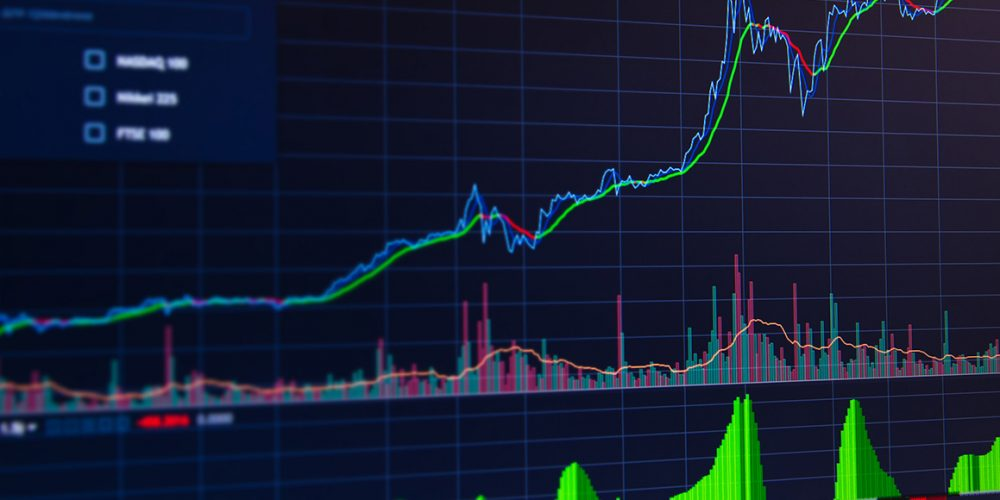

Time Series data is a series of data points indexed in time order. Time series data is everywhere, so manipulating them is important for any data analyst or data scientist.

In this notebook, we will discover and explore data from the stock market, particularly some technology stocks (Apple, Amazon, Google, and Microsoft). We will learn how to use yfinance to get stock information, and visualize different aspects of it using Seaborn and Matplotlib. we will look at a few ways of analyzing the risk of a stock, based on its previous performance history. We will also be predicting future stock prices through a Long Short Term Memory (LSTM) method!

We'll be answering the following questions along the way:

    1.) What was the change in price of the stock over time?
    2.) What was the daily return of the stock on average?
    3.) What was the moving average of the various stocks?
    4.) What was the correlation between different stocks'?
    5.) How much value do we put at risk by investing in a particular stock?
    6.) How can we attempt to predict future stock behavior? (Predicting the closing price stock price of APPLE inc using LSTM)

***   

## Getting the Data
The first step is to get the data and load it to memory. We will get our stock data from the Yahoo Finance website. Yahoo Finance is a rich resource of financial market data and tools to find compelling investments. To get the data from Yahoo Finance, we will be using yfinance library which offers a threaded and Pythonic way to download market data from Yahoo. Check this article to learn more about yfinance: [Reliably download historical market data from with Python](https://aroussi.com/post/python-yahoo-finance)

# 1. What was the change in price of the stock overtime?

In this section we'll go over how to handle requesting stock information with pandas, and how to analyze basic attributes of a stock.

In [185]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime


# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)
    

company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df.tail(10)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2023-10-30,129.720001,133.000000,128.559998,132.710007,132.710007,72485500,AMAZON
2023-10-31,132.750000,133.570007,131.710007,133.089996,133.089996,51589400,AMAZON
2023-11-01,133.960007,137.350006,133.710007,137.000000,137.000000,61529400,AMAZON
2023-11-02,138.729996,138.809998,136.470001,138.070007,138.070007,52236700,AMAZON
2023-11-03,138.990005,139.490005,137.449997,138.600006,138.600006,44007200,AMAZON
2023-11-06,138.759995,140.729996,138.360001,139.740005,139.740005,44970400,AMAZON
2023-11-07,140.550003,143.369995,140.500000,142.710007,142.710007,53553500,AMAZON
2023-11-08,142.970001,143.119995,141.220001,142.080002,142.080002,44521700,AMAZON
2023-11-09,142.020004,142.649994,139.839996,140.600006,140.600006,36235400,AMAZON


Reviewing the content of our data, we can see that the data is numeric and the date is the index of the data. Notice also that weekends are missing from the records.

**Quick note:** Using `globals()` is a sloppy way of setting the `DataFrame` names, but it's simple. Now we have our data, let's perform some basic data analysis and check our data.

## Descriptive Statistics about the Data
`.describe()` generates descriptive statistics. Descriptive statistics include those that summarize the central tendency, dispersion, and shape of a dataset’s distribution, excluding `NaN` values.

Analyzes both numeric and object series, as well as `DataFrame` column sets of mixed data types. The output will vary depending on what is provided. Refer to the notes below for more detail.

In [186]:
# Summary Stats
GOOG.describe()

,Open,High,Low,Close,Adj Close,Volume
count,250.000000,250.000000,250.000000,250.000000,250.000000,2.500000e+02
mean,113.775220,115.259840,112.638536,114.008500,114.008500,2.572534e+07
std,16.789154,16.814829,16.729840,16.756061,16.756061,1.063936e+07
min,86.720001,88.209999,85.570000,86.459999,86.459999,8.567800e+06
25%,97.900000,99.434999,96.744999,98.087498,98.087498,1.944155e+07
50%,116.795002,118.617500,116.515003,117.334999,117.334999,2.280480e+07
75%,129.547497,130.936996,128.423756,129.607502,129.607502,2.829615e+07
max,142.160004,142.380005,139.839996,141.699997,141.699997,9.779860e+07


We have only 255 records in one year because weekends are not included in the data.

## Information About the Data
`.info()` method prints information about a DataFrame including the index `dtype` and columns, non-null values, and memory usage.

In [187]:
# General info
GOOG.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2022-11-14 to 2023-11-10
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          250 non-null    float64
 1   High          250 non-null    float64
 2   Low           250 non-null    float64
 3   Close         250 non-null    float64
 4   Adj Close     250 non-null    float64
 5   Volume        250 non-null    int64  
 6   company_name  250 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.6+ KB


## Closing Price

The closing price is the last price at which the stock is traded during the regular trading day. A stock’s closing price is the standard benchmark used by investors to track its performance over time.

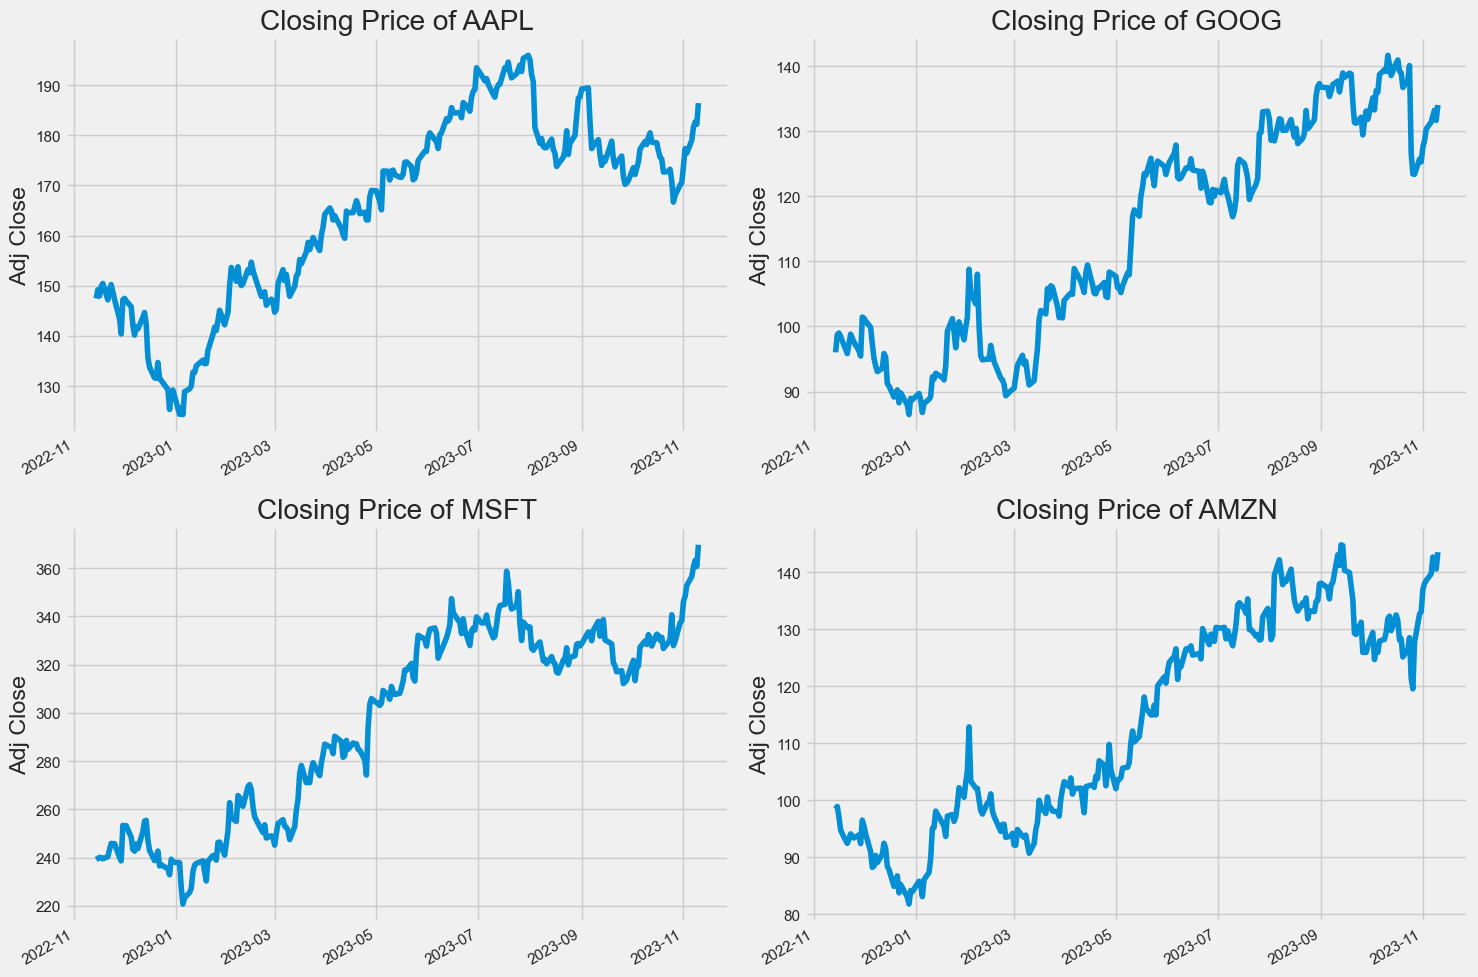

In [188]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

## Volume of Sales
Volume is the amount of an asset or security that changes hands over some period of time, often over the course of a day. For instance, the stock trading volume would refer to the number of shares of security traded between its daily open and close. Trading volume, and changes to volume over the course of time, are important inputs for technical traders.

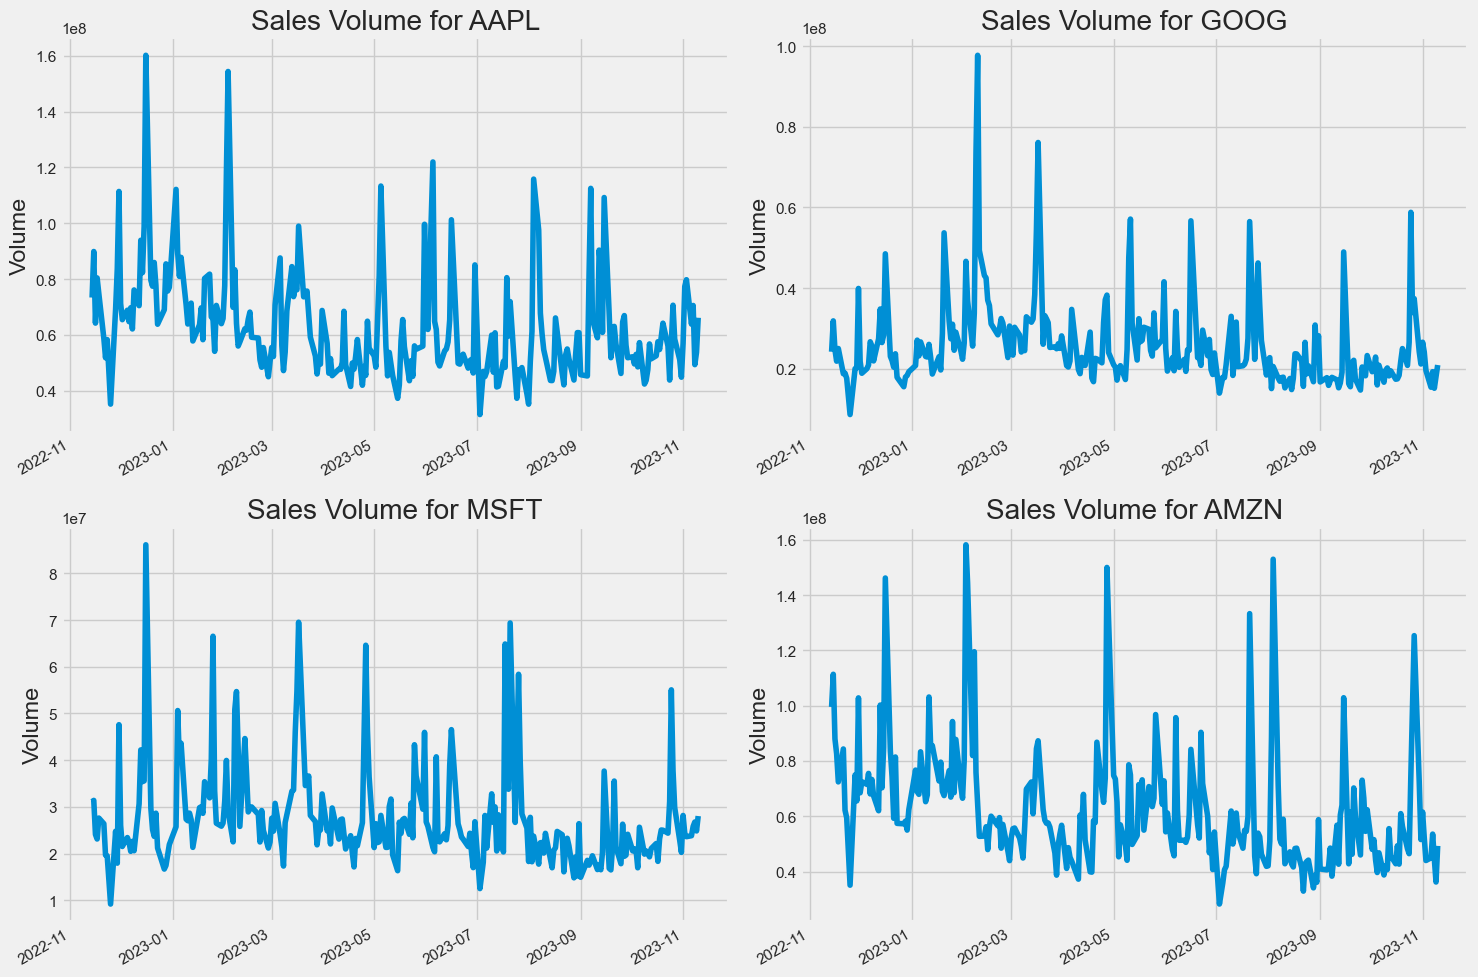

In [189]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {tech_list[i - 1]}")
    
plt.tight_layout()

Now that we've seen the visualizations for the closing price and the volume traded each day, let's go ahead and caculate the moving average for the stock.

# 2. What was the moving average of the various stocks?

The moving average (MA) is a simple technical analysis tool that smooths out price data by creating a constantly updated average price. The average is taken over a specific period of time, like 10 days, 20 minutes, 30 weeks, or any time period the trader chooses.

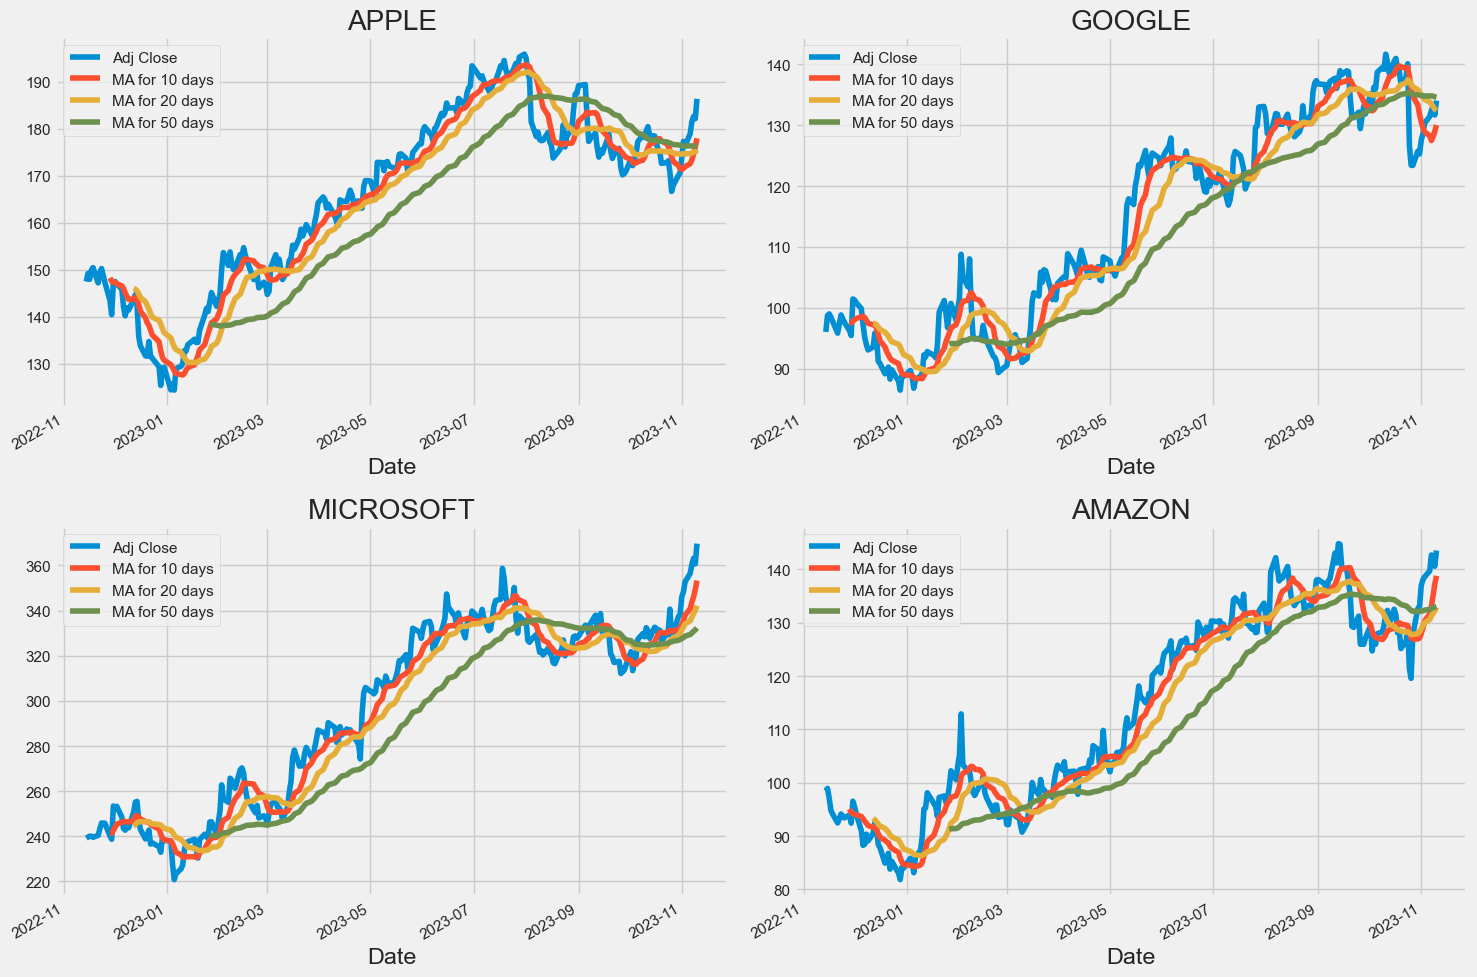

In [190]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()
        

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

GOOG[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')

MSFT[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT')

AMZN[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')

fig.tight_layout()

We see in the graph that the best values to measure the moving average are 10 and 20 days because we still capture trends in the data without noise.

# 3. What was the daily return of the stock on average?

Now that we've done some baseline analysis, let's go ahead and dive a little deeper. We're now going to analyze the risk of the stock. In order to do so we'll need to take a closer look at the daily changes of the stock, and not just its absolute value. Let's go ahead and use pandas to retrieve teh daily returns for the Apple stock.

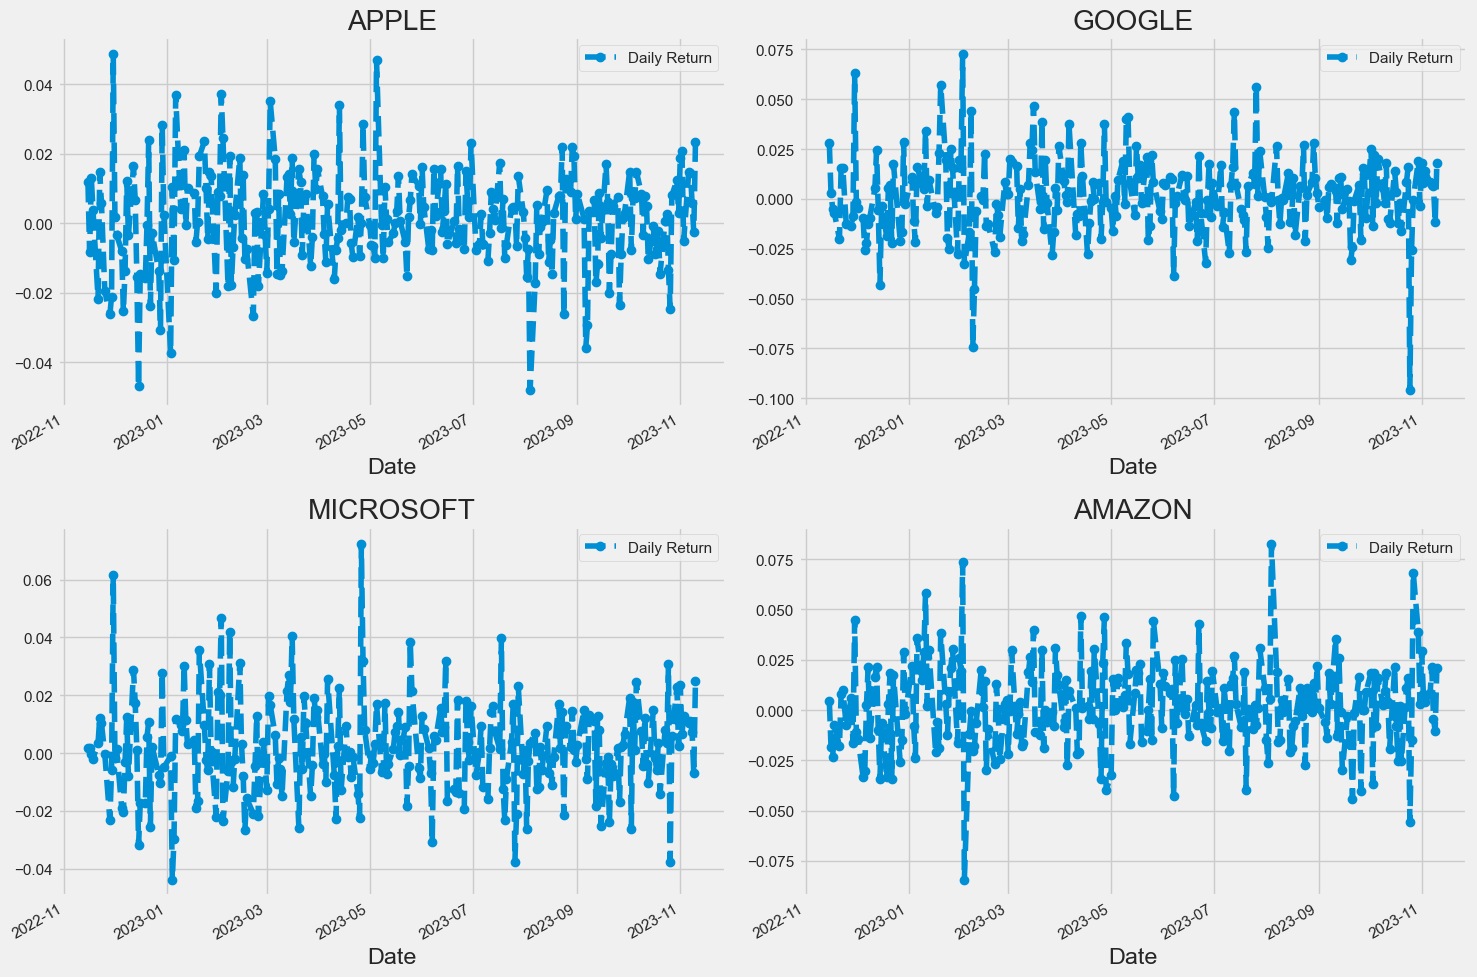

In [191]:
# We'll use pct_change to find the percent change for each day
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')

GOOG['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GOOGLE')

MSFT['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT')

AMZN['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMAZON')

fig.tight_layout()

Great, now let's get an overall look at the average daily return using a histogram. We'll use seaborn to create both a histogram and kde plot on the same figure.

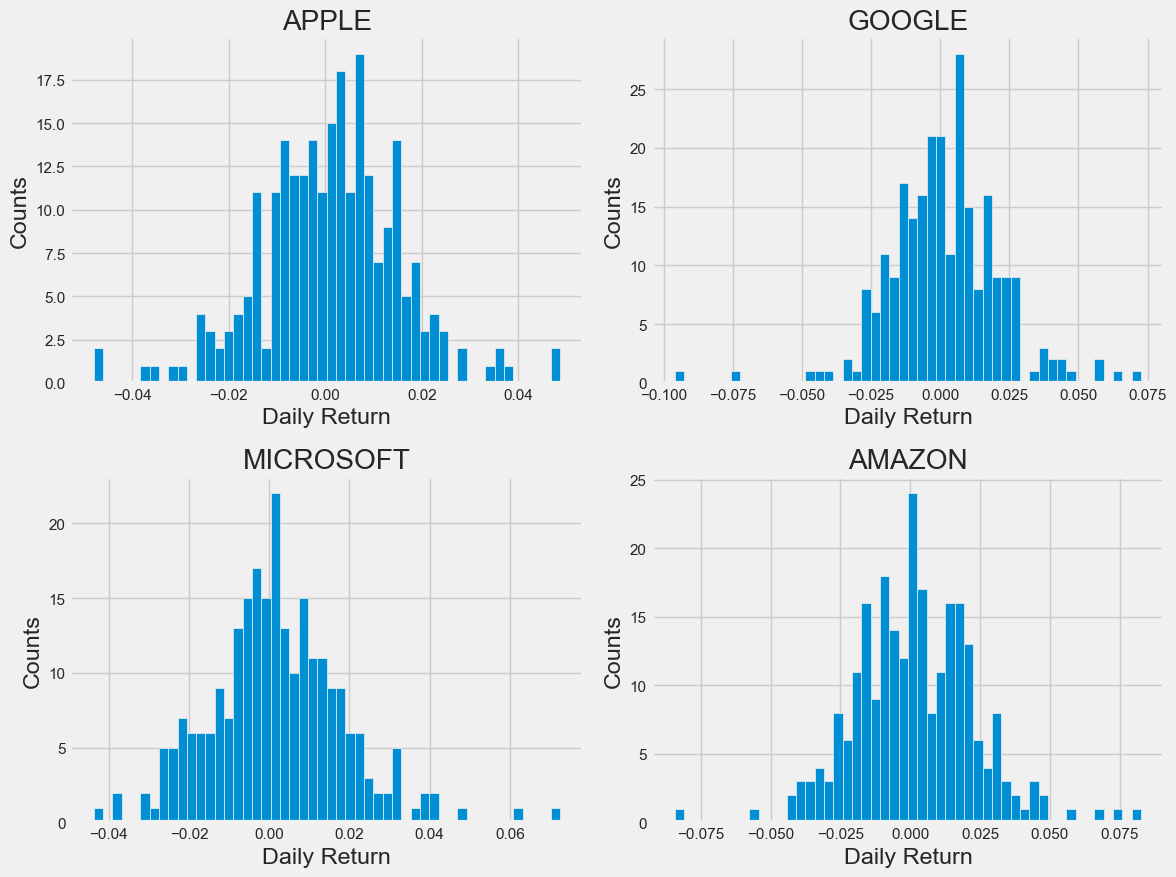

In [192]:
plt.figure(figsize=(12, 9))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Return'].hist(bins=50)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{company_name[i - 1]}')
    
plt.tight_layout()

# 4. What was the correlation between different stocks closing prices?

Correlation is a statistic that measures the degree to which two variables move in relation to each other which has a value that must fall between -1.0 and +1.0. Correlation measures association, but doesn’t show if x causes y or vice versa — or if the association is caused by a third factor[1].

Now what if we wanted to analyze the returns of all the stocks in our list? Let's go ahead and build a DataFrame with all the ['Close'] columns for each of the stocks dataframes.

In [193]:
# Grab all the closing prices for the tech stock list into one DataFrame

closing_df = pdr.get_data_yahoo(tech_list, start=start, end=end)['Adj Close']

# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()
tech_rets.head()

[*********************100%%**********************]  4 of 4 completed


,AAPL,AMZN,GOOG,MSFT
Date,,,,
2022-11-14,NaN,NaN,NaN,NaN
2022-11-15,0.011870,0.004569,0.028012,0.001739
2022-11-16,-0.008331,-0.018395,0.002735,0.001823
2022-11-17,0.012971,-0.023373,-0.004950,-0.000207
2022-11-18,0.003782,-0.007485,-0.007107,-0.001903


Now we can compare the daily percentage return of two stocks to check how correlated. First let's see a sotck compared to itself.

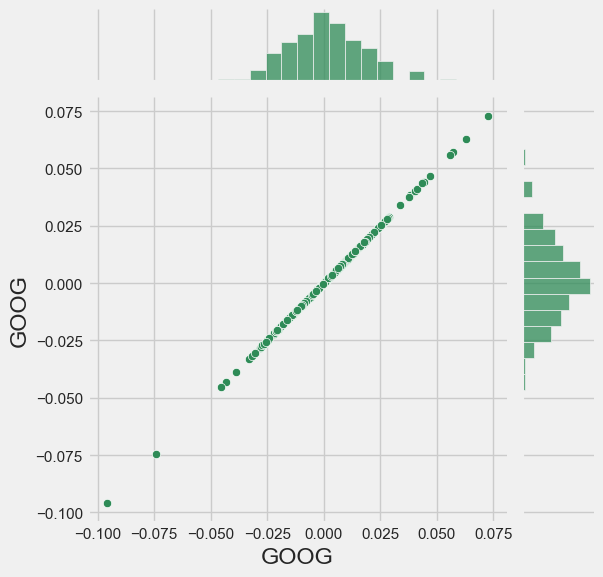

In [194]:
# Comparing Google to itself should show a perfectly linear relationship
sns.jointplot(x='GOOG', y='GOOG', data=tech_rets, kind='scatter', color='seagreen')

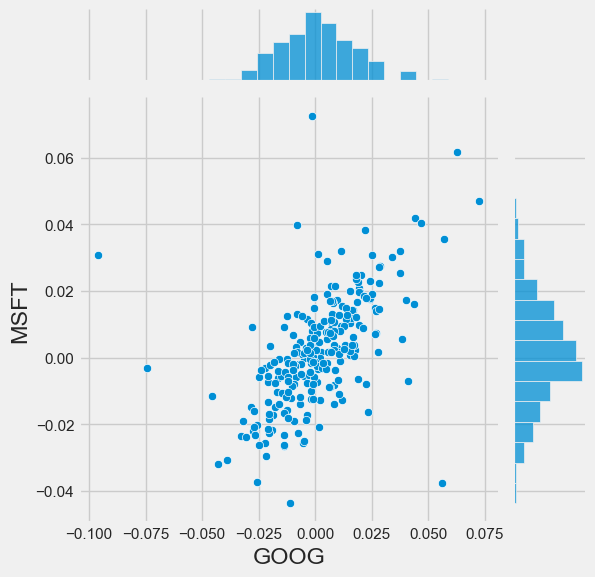

In [195]:
# We'll use joinplot to compare the daily returns of Google and Microsoft
sns.jointplot(x='GOOG', y='MSFT', data=tech_rets, kind='scatter')

So now we can see that if two stocks are perfectly (and positivley) correlated with each other a linear relationship bewteen its daily return values should occur. 

Seaborn and pandas make it very easy to repeat this comparison analysis for every possible combination of stocks in our technology stock ticker list. We can use sns.pairplot() to automatically create this plot

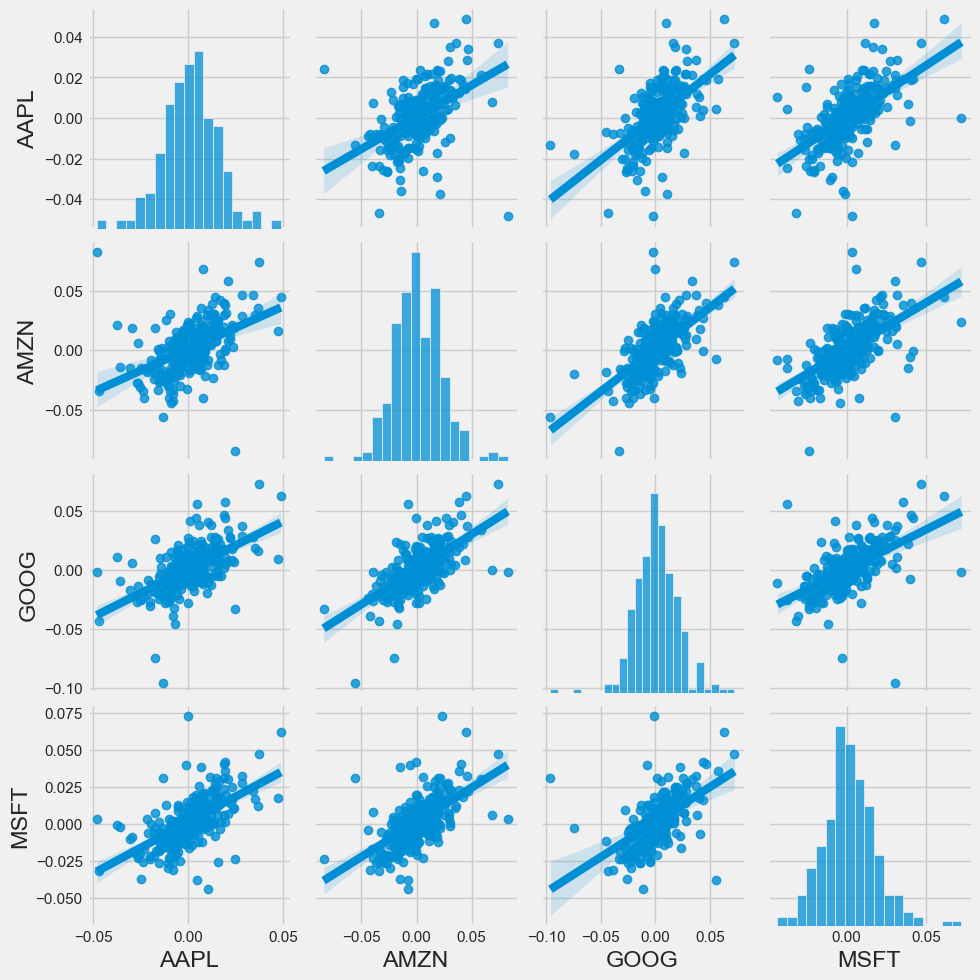

In [196]:
# We can simply call pairplot on our DataFrame for an automatic visual analysis 
# of all the comparisons

sns.pairplot(tech_rets, kind='reg')

Above we can see all the relationships on daily returns between all the stocks. A quick glance shows an interesting correlation between Google and Amazon daily returns. It might be interesting to investigate that individual comaprison. 


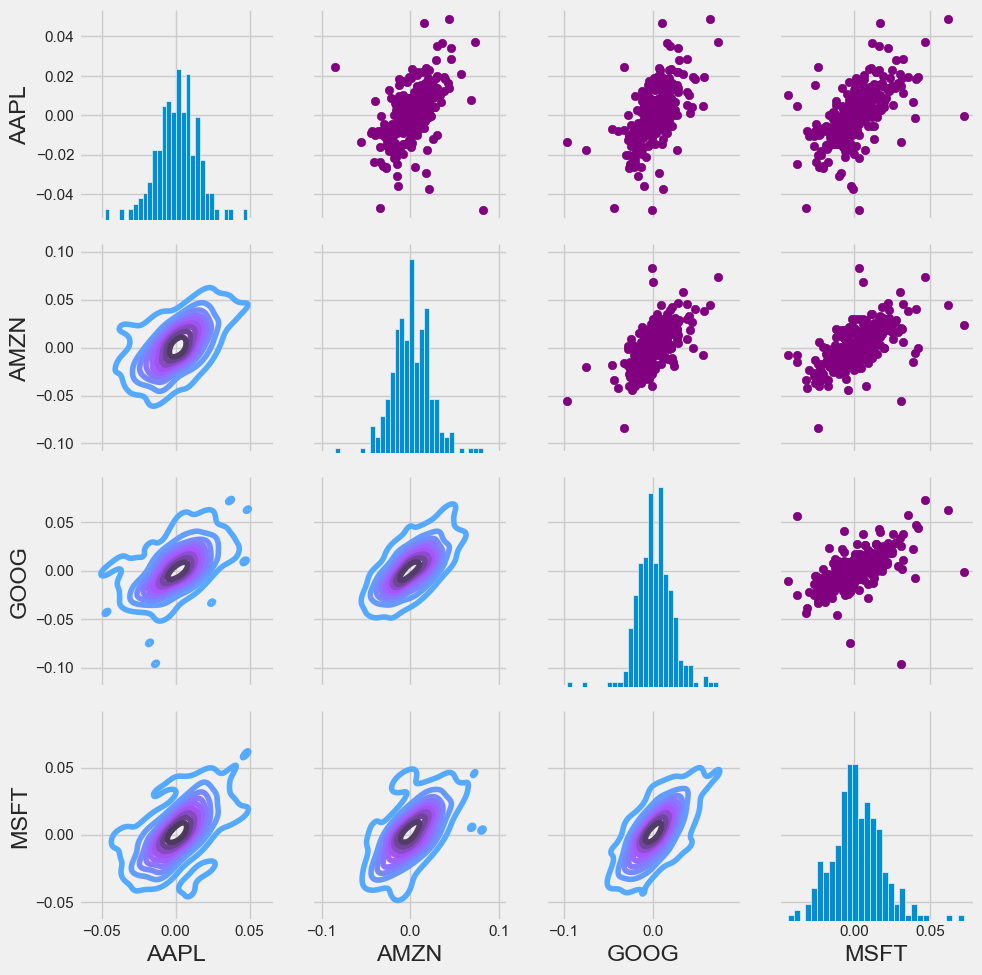

In [197]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
return_fig = sns.PairGrid(tech_rets.dropna())

# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) 
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

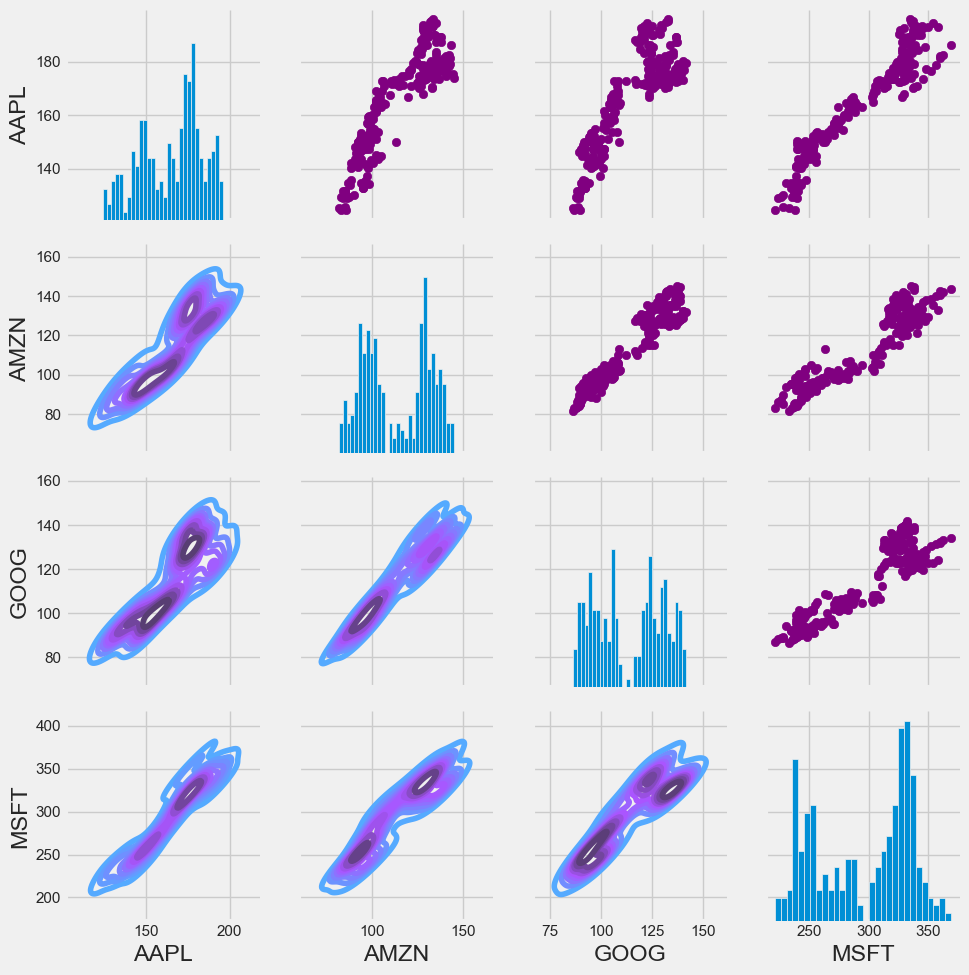

In [198]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
returns_fig = sns.PairGrid(closing_df)

# Using map_upper we can specify what the upper triangle will look like.
returns_fig.map_upper(plt.scatter,color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
returns_fig.map_diag(plt.hist,bins=30)

Finally, we could also do a correlation plot, to get actual numerical values for the correlation between the stocks' daily return values. By comparing the closing prices, we see an interesting relationship between Microsoft and Apple.

Text(0.5, 1.0, 'Correlation of stock closing price')

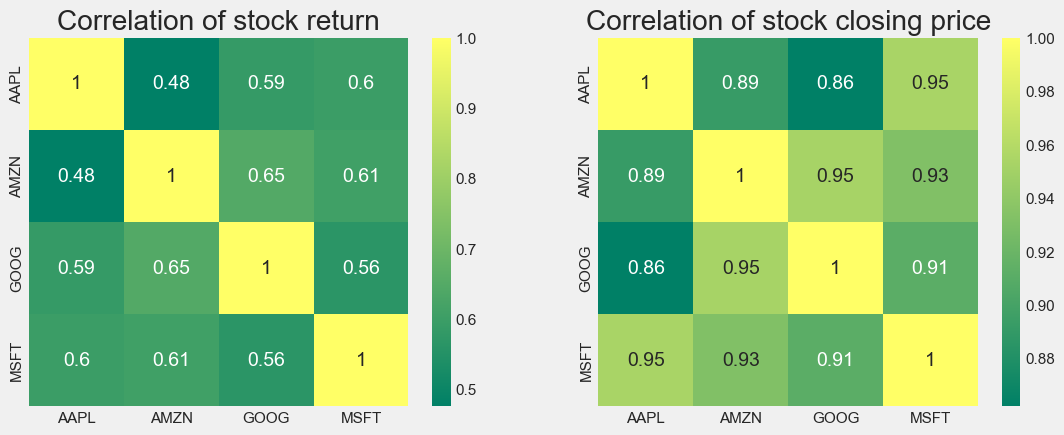

In [199]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

Just like we suspected in our `PairPlot` we see here numerically and visually that Microsoft and Amazon had the strongest correlation of daily stock return. It's also interesting to see that all the technology comapnies are positively correlated.

# 5. How much value do we put at risk by investing in a particular stock?

There are many ways we can quantify risk, one of the most basic ways using the information we've gathered on daily percentage returns is by comparing the expected return with the standard deviation of the daily returns.

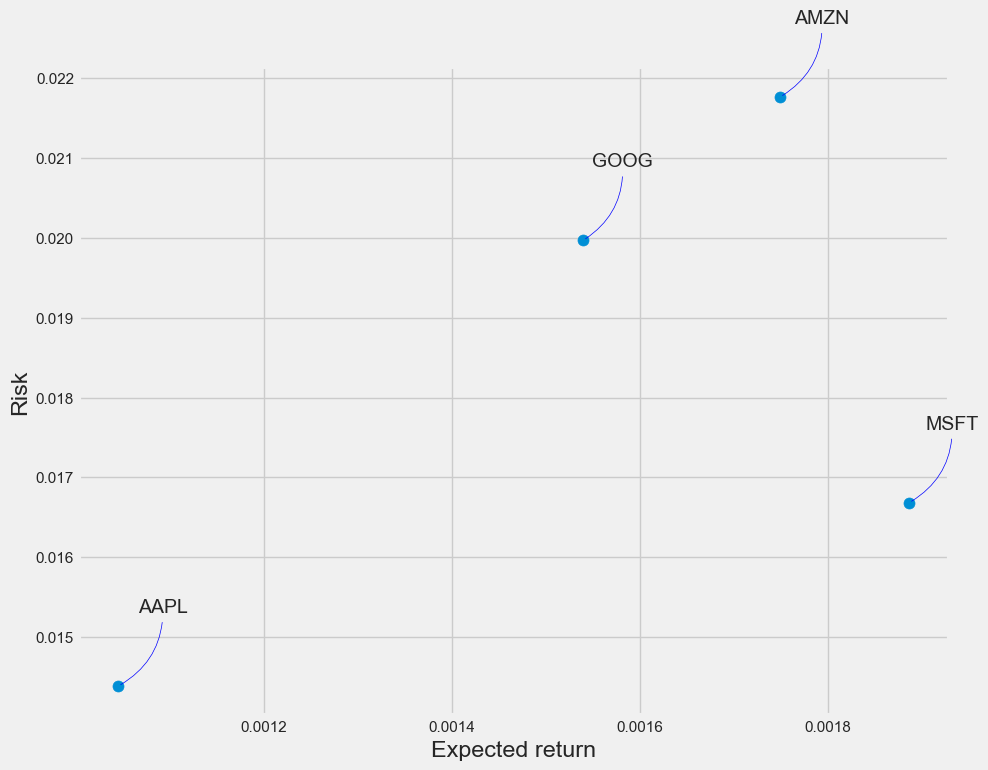

In [200]:
rets = tech_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

# 6. Simple Predicting the closing price stock price of APPLE inc using no Feature Extraction:

In [201]:
# Get the stock quote
df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())
# Show teh data
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.449691,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.516597,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.655551,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.787855,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.767570,394024400
...,...,...,...,...,...,...
2023-11-06,176.380005,179.429993,176.210007,179.229996,178.994186,63841300
2023-11-07,179.179993,182.440002,178.970001,181.820007,181.580780,70530000
2023-11-08,182.350006,183.449997,181.589996,182.889999,182.649368,49340300


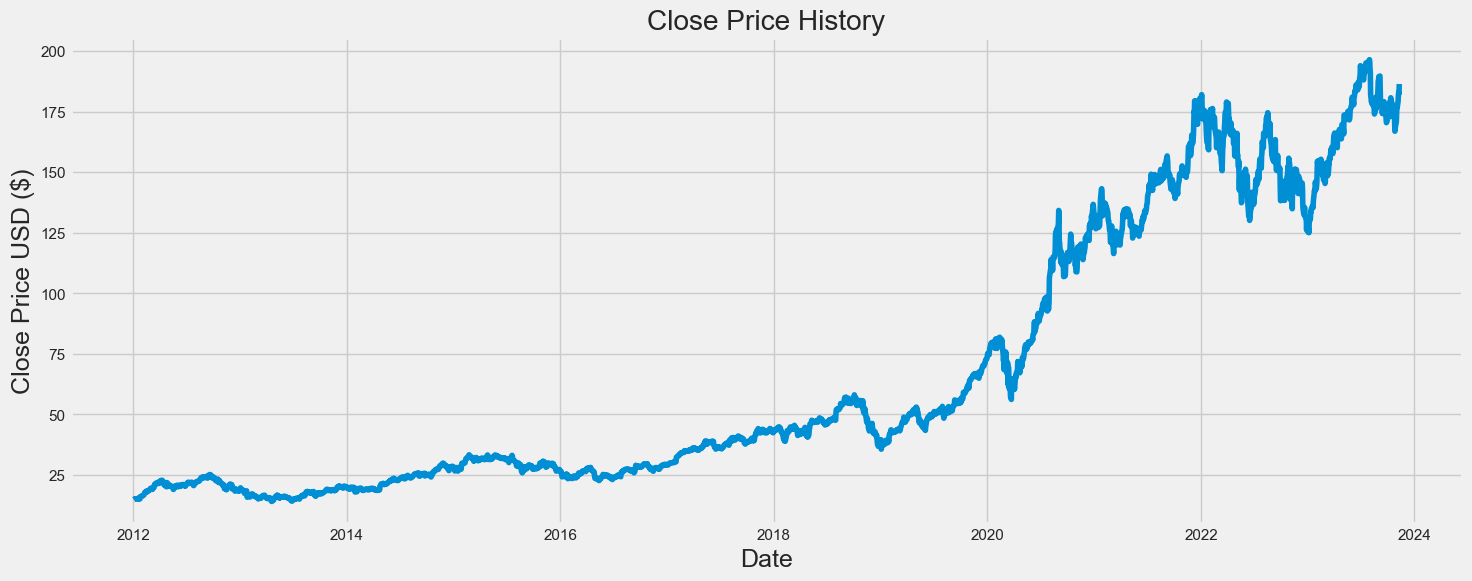

In [202]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [203]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

2836

In [204]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00405082],
       [0.0044833 ],
       [0.00538153],
       ...,
       [0.92569966],
       [0.92306958],
       [0.94493224]])

In [205]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.00405082, 0.0044833 , 0.00538153, 0.0062367 , 0.00610559,
       0.00640108, 0.00626606, 0.00603905, 0.00572986, 0.0066868 ,
       0.0075498 , 0.00728366, 0.00582575, 0.00721712, 0.00584728,
       0.01098419, 0.01058694, 0.01110552, 0.01222684, 0.01290588,
       0.01284914, 0.01263975, 0.0135321 , 0.01437162, 0.01532269,
       0.01685887, 0.02008583, 0.02013475, 0.02193121, 0.02327365,
       0.02096645, 0.02185489, 0.02183728, 0.02432844, 0.02397423,
       0.02462979, 0.02580786, 0.02646344, 0.02835186, 0.02972757,
       0.03012483, 0.03026377, 0.02791156, 0.02734404, 0.0274282 ,
       0.02963952, 0.03026182, 0.0315984 , 0.03474903, 0.0389525 ,
       0.03816582, 0.03816777, 0.04120687, 0.04215794, 0.04148084,
       0.04086246, 0.04021863, 0.04235754, 0.04382523, 0.04443971])]
[0.04292113229660477]

[array([0.00405082, 0.0044833 , 0.00538153, 0.0062367 , 0.00610559,
       0.00640108, 0.00626606, 0.00603905, 0.00572986, 0.0066868 ,
       0.0075498 , 0.00728366, 0.00

In [206]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2776/2776 [==============================] - 71s 25ms/step - loss: 0.0014


In [207]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5/5 [==============================] - 1s 30ms/step


7.2863451565824615

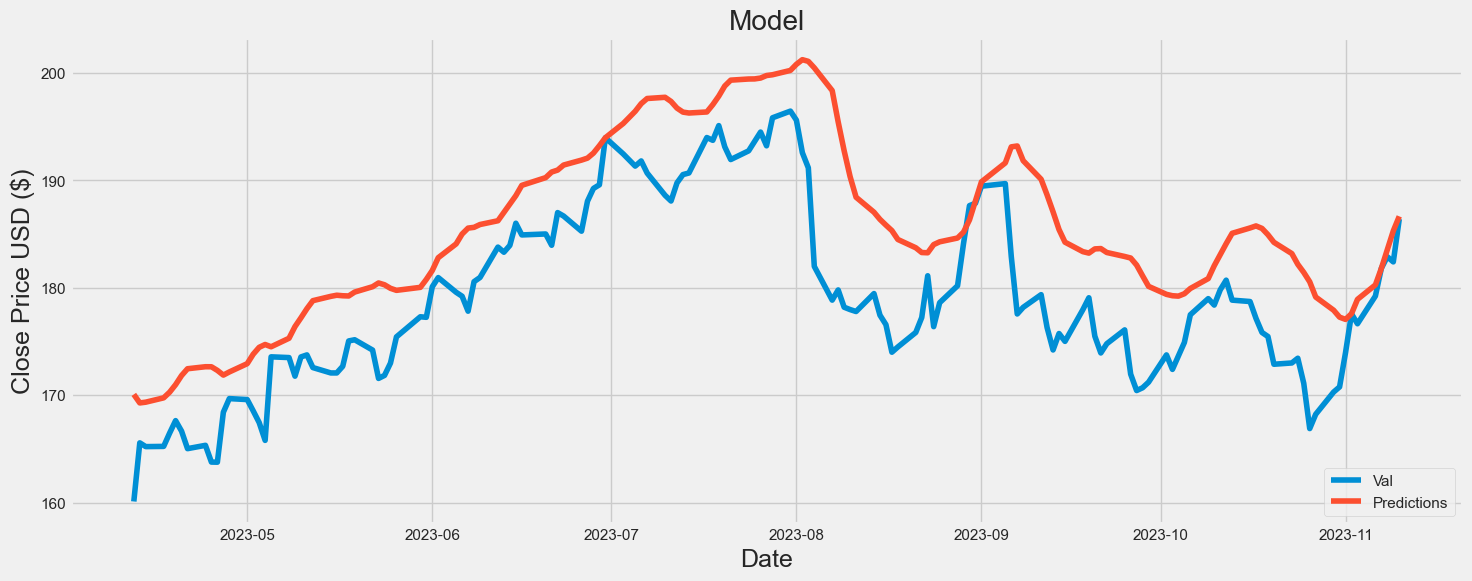

In [208]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [209]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2023-04-12,160.100006,170.070190
2023-04-13,165.559998,169.277786
2023-04-14,165.210007,169.349060
2023-04-17,165.229996,169.750565
2023-04-18,166.470001,170.277298
...,...,...
2023-11-06,179.229996,180.266174
2023-11-07,181.820007,181.808594
2023-11-08,182.889999,183.569275


In [210]:
# Relative Strength Index
# Avg(PriceUp)/(Avg(PriceUP)+Avg(PriceDown)*100
# Where: PriceUp(t)=1*(Price(t)-Price(t-1)){Price(t)- Price(t-1)>0};
#        PriceDown(t)=-1*(Price(t)-Price(t-1)){Price(t)- Price(t-1)<0};

def rsi(values):
    up = values[values>0].mean()
    down = -1*values[values<0].mean()
    return 100 * up / (up + down)
def bbands(price, length=30, numsd=2):
    """ returns average, upper band, and lower band"""
    #ave = pd.stats.moments.rolling_mean(price,length)
    ave = price.rolling(window = length, center = False).mean()
    #sd = pd.stats.moments.rolling_std(price,length)
    sd = price.rolling(window = length, center = False).std()
    upband = ave + (sd*numsd)
    dnband = ave - (sd*numsd)
    return np.round(ave,3), np.round(upband,3), np.round(dnband,3)


In [211]:
# Add Momentum_1D column for all 15 stocks.
# Momentum_1D = P(t) - P(t-1)

df['Momentum_1D'] = (df['Close']-df['Close'].shift(1)).fillna(0)
df['RSI_14D'] = df['Momentum_1D'].rolling(center=False, window=14).apply(rsi).fillna(0)
df['Volume_plain'] = df['Volume'].fillna(0)

df['BB_Middle_Band'], df['BB_Upper_Band'], df['BB_Lower_Band'] = bbands(df['Close'], length=20, numsd=1)
df['BB_Middle_Band'] = df['BB_Middle_Band'].fillna(0)
df['BB_Upper_Band'] = df['BB_Upper_Band'].fillna(0)
df['BB_Lower_Band'] = df['BB_Lower_Band'].fillna(0)


df['VWAP'] = np.cumsum(df['Volume'] * (df['High'] +df['Low'])/2) / np.cumsum(df['Volume'])
df['HL'] = df['High'] - df['Low']
df['absHC'] = abs(df['High'] - df['Close'].shift(1))
df['absLC'] = abs(df['Low'] - df['Close'].shift(1))
df['TR'] = df[['HL','absHC','absLC']].max(axis=1)
df['ATR'] = df['TR'].rolling(window=14).mean()
df['NATR'] = (df['ATR'] / df['Close']) *100
df =df.fillna(0)
df.tail(5)

,Open,High,Low,Close,Adj Close,Volume,Momentum_1D,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,VWAP,HL,absHC,absLC,TR,ATR,NATR
Date,,,,,,,,,,,,,,,,,,,
2023-11-06,176.380005,179.429993,176.210007,179.229996,178.994186,63841300,2.580002,46.889845,63841300,174.947,178.970,170.923,43.341207,3.219986,2.779999,0.439987,3.219986,3.298572,1.840413
2023-11-07,179.179993,182.440002,178.970001,181.820007,181.580780,70530000,2.590012,46.640528,70530000,175.118,179.363,170.873,43.358015,3.470001,3.210007,0.259995,3.470001,3.370001,1.853482
2023-11-08,182.350006,183.449997,181.589996,182.889999,182.649368,49340300,1.069992,41.028019,49340300,175.273,179.747,170.798,43.369925,1.860001,1.629990,0.230011,1.860001,3.313572,1.811784
2023-11-09,182.960007,184.119995,181.809998,182.410004,182.169998,53763500,-0.479996,46.794249,53763500,175.358,179.955,170.760,43.382943,2.309998,1.229996,1.080002,2.309998,3.277143,1.796581
2023-11-10,183.970001,186.570007,183.529999,186.399994,186.399994,66133400,3.989990,51.788932,66133400,175.735,180.908,170.562,43.399192,3.040009,4.160004,1.119995,4.160004,3.282858,1.761190


Text(0, 0.5, 'Close Prices')

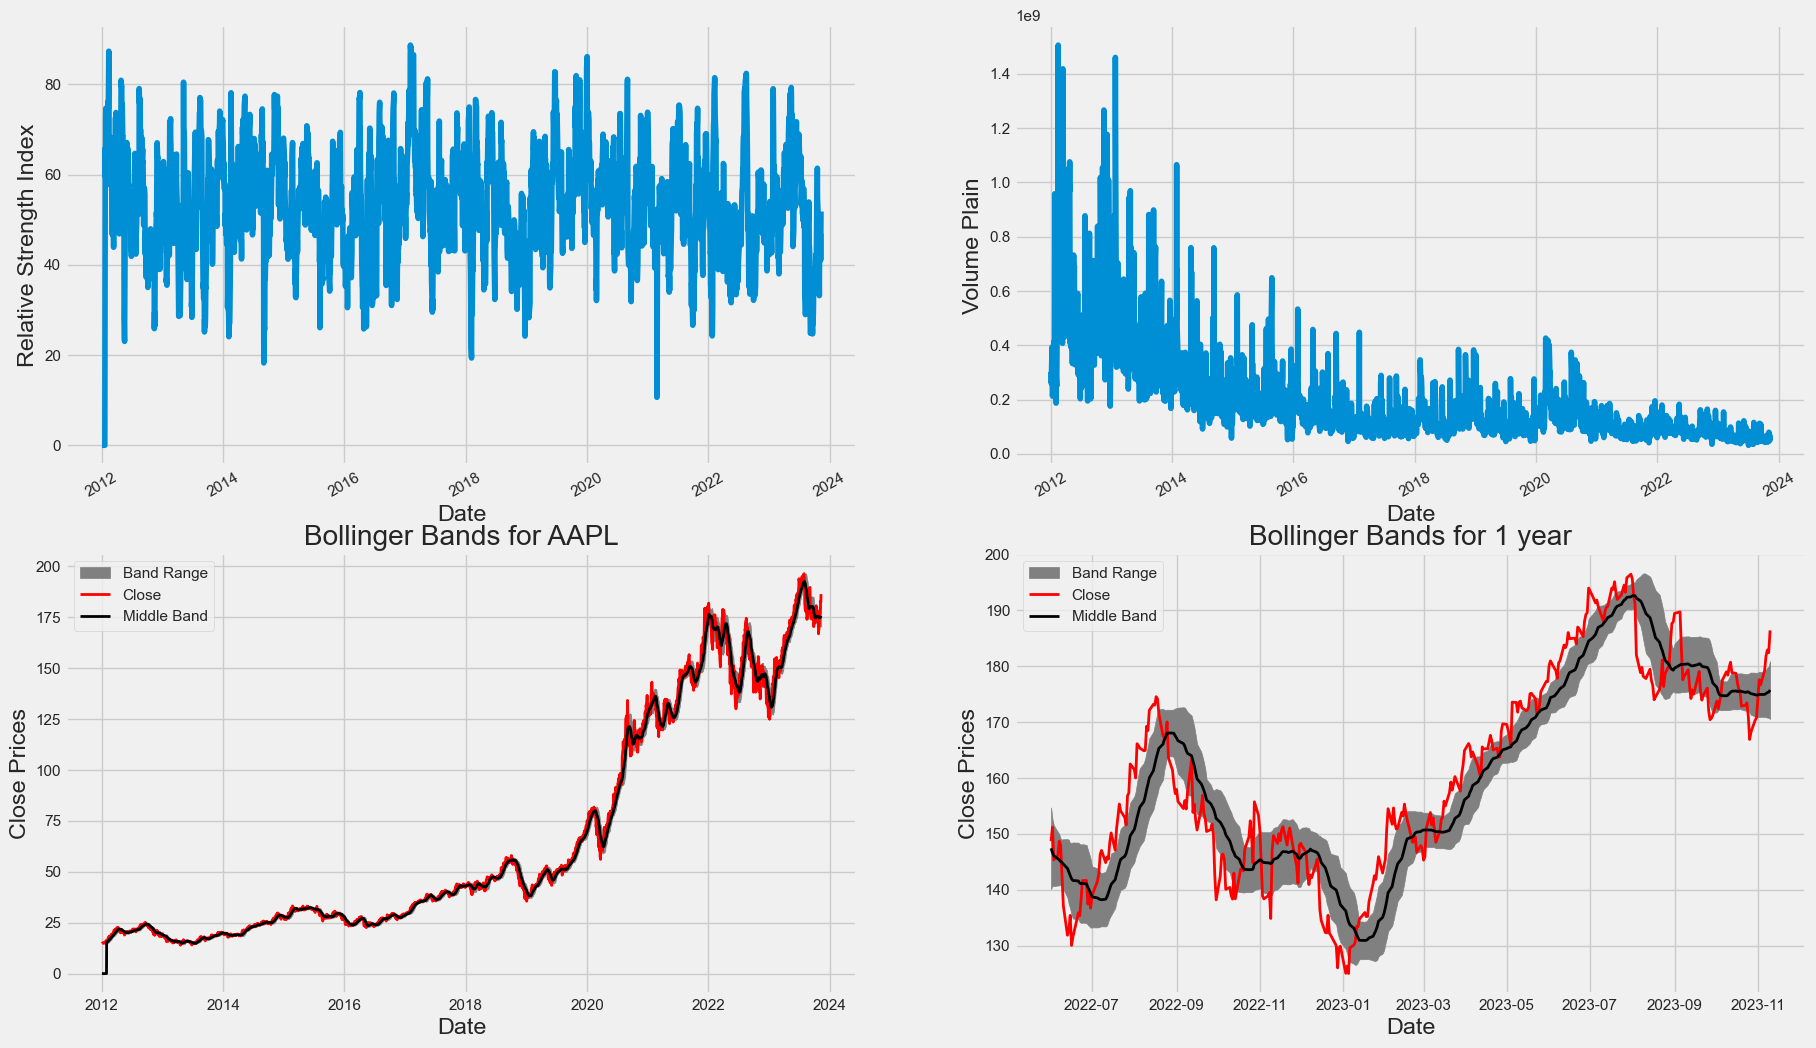

In [212]:
plt.figure(figsize=(20,25))
#RSI
plt.subplot(4,2,1)
plt.plot(df.index, df['RSI_14D'])
plt.xlabel("Date")
plt.ylabel("Relative Strength Index")
plt.xticks(rotation=30)

#Volume plain
plt.subplot(4,2,2)
plt.plot(df.index, df['Volume_plain'])
plt.xlabel("Date")
plt.ylabel("Volume Plain")
plt.xticks(rotation=30)

#Bollinger Band
plt.subplot(4,2,3)

plt.fill_between(df.index, df['BB_Upper_Band'], df['BB_Lower_Band'], color='grey', label="Band Range")
# Plot Adjust Closing Price and Moving Averages

plt.plot(df.index, df['Close'], color='red', lw=2, label="Close")
plt.plot(df.index, df['BB_Middle_Band'], color='black', lw=2, label="Middle Band")
plt.title("Bollinger Bands for AAPL" )
plt.legend()
plt.xlabel("Date")
plt.ylabel("Close Prices")
#LAst year Bolliger Band
subdf = df.tail(365)
plt.subplot(4,2,4)
plt.fill_between(subdf.index, subdf['BB_Upper_Band'], subdf['BB_Lower_Band'], color='grey', label="Band Range")
plt.plot(subdf.index, subdf['Close'], color='red', lw=2, label="Close")
plt.plot(subdf.index, subdf['BB_Middle_Band'], color='black', lw=2, label="Middle Band")
plt.title("Bollinger Bands for 1 year" )
plt.legend()
plt.xlabel("Date")
plt.ylabel("Close Prices")


(array([14610., 15340., 16071., 16801., 17532., 18262., 18993., 19723.]),
 [Text(14610.0, 0, '2010'),
  Text(15340.0, 0, '2012'),
  Text(16071.0, 0, '2014'),
  Text(16801.0, 0, '2016'),
  Text(17532.0, 0, '2018'),
  Text(18262.0, 0, '2020'),
  Text(18993.0, 0, '2022'),
  Text(19723.0, 0, '2024')])

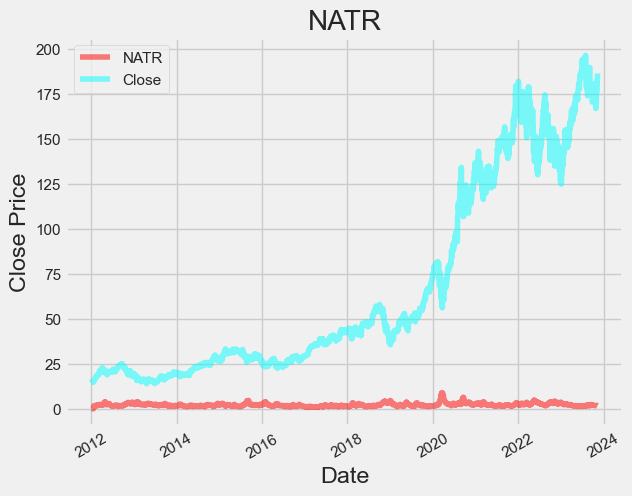

In [213]:

plt.plot(df.index, df['NATR'], 'red', label="NATR", alpha = 0.5)
plt.plot(df.index, df['Close'], 'cyan', label="Close", alpha = 0.5)
plt.title("NATR" )
plt.legend()
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.xticks(rotation=30)

In [214]:
fc= ['NATR','VWAP', 'BB_Middle_Band', 'RSI_14D','Volume_plain','Momentum_1D','Adj Close']
feature_minmax_transform_data = scaler.fit_transform(df[fc])
feature_minmax_transform = pd.DataFrame(columns=fc, data=feature_minmax_transform_data, index=df.index)
feature_minmax_transform.median()

NATR              0.229851
VWAP              0.277386
BB_Middle_Band    0.208600
RSI_14D           0.601772
Volume_plain      0.067606
Momentum_1D       0.468361
Adj Close         0.143408
dtype: float64

In [215]:
display(feature_minmax_transform.head())
target_adj_close = pd.DataFrame(df['Adj Close'])
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target_adj_close.shape)

# Shift target array because we want to predict the n + 1 day value


target_adj_close = target_adj_close.shift(-1)
validation_y = target_adj_close[-90:-1]
target_adj_close = target_adj_close[:-90]

# Taking last 20 rows of data to be validation set
validation_X = feature_minmax_transform[-90:-1]
feature_minmax_transform = feature_minmax_transform[:-90]
display(validation_X.tail())
display(validation_y.tail())

print("\n -----After process------ \n")
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target_adj_close.shape)
display(target_adj_close.tail())

,NATR,VWAP,BB_Middle_Band,RSI_14D,Volume_plain,Momentum_1D,Adj Close
Date,,,,,,,
2012-01-03,0.0,0.000000,0.0,0.0,0.183610,0.467140,0.002458
2012-01-04,0.0,0.000707,0.0,0.0,0.154994,0.470645,0.002822
2012-01-05,0.0,0.002443,0.0,0.0,0.162621,0.474420,0.003578
2012-01-06,0.0,0.005284,0.0,0.0,0.194509,0.474071,0.004297
2012-01-09,0.0,0.008310,0.0,0.0,0.245864,0.466078,0.004187


Shape of features :  (2985, 7)
Shape of target :  (2985, 1)


,NATR,VWAP,BB_Middle_Band,RSI_14D,Volume_plain,Momentum_1D,Adj Close
Date,,,,,,,
2023-11-03,0.212954,0.997463,0.908131,0.516362,0.032757,0.426287,0.893930
2023-11-06,0.206755,0.997982,0.908193,0.528833,0.021960,0.581705,0.907939
2023-11-07,0.208223,0.998567,0.909081,0.526021,0.026495,0.582150,0.922002
2023-11-08,0.203539,0.998981,0.909885,0.462722,0.012126,0.514653,0.927812
2023-11-09,0.201831,0.999434,0.910326,0.527755,0.015126,0.445826,0.925205


,Adj Close
Date,
2023-11-03,178.994186
2023-11-06,181.580780
2023-11-07,182.649368
2023-11-08,182.169998
2023-11-09,186.399994



 -----After process------ 

Shape of features :  (2895, 7)
Shape of target :  (2895, 1)


,Adj Close
Date,
2023-06-29,193.453568
2023-06-30,191.947586
2023-07-03,190.820587
2023-07-05,191.299301
2023-07-06,190.172302


In [216]:
from sklearn.model_selection import TimeSeriesSplit
ts_split= TimeSeriesSplit(n_splits=800)
for train_index, test_index in ts_split.split(feature_minmax_transform):
        X_train, X_test = feature_minmax_transform[:len(train_index)], feature_minmax_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = target_adj_close[:len(train_index)].values.ravel(), target_adj_close[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [217]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates

def validate_result(model, model_name):
    predicted = model.predict(validation_X)
    RSME_score = np.sqrt(mean_squared_error(validation_y, predicted))
    print('RMSE: ', RSME_score)
    
    R2_score = r2_score(validation_y, predicted)
    print('R2 score: ', R2_score)

    plt.plot(validation_y.index, predicted,'r', label='Predict')
    plt.plot(validation_y.index, validation_y,'b', label='Actual')
    plt.ylabel('Price')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.title(model_name + ' Predict vs Actual')
    plt.legend(loc='upper right')
    plt.show()

RMSE:  9.171466114299898
R2 score:  -0.48000341258704404


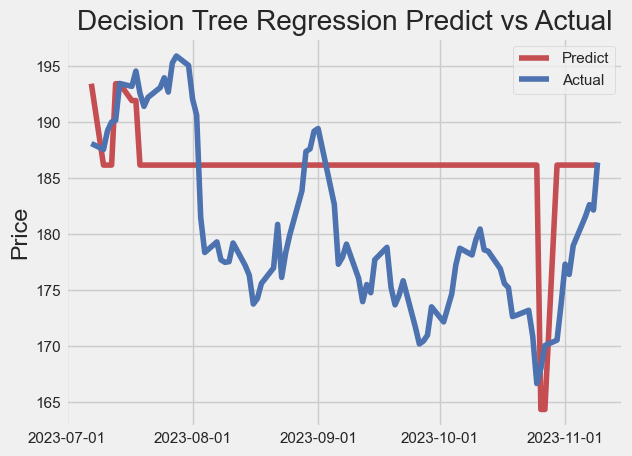

          Feature  Importance
1            VWAP    0.885311
6       Adj Close    0.114081
0            NATR    0.000160
2  BB_Middle_Band    0.000119
3         RSI_14D    0.000113
5     Momentum_1D    0.000111
4    Volume_plain    0.000106


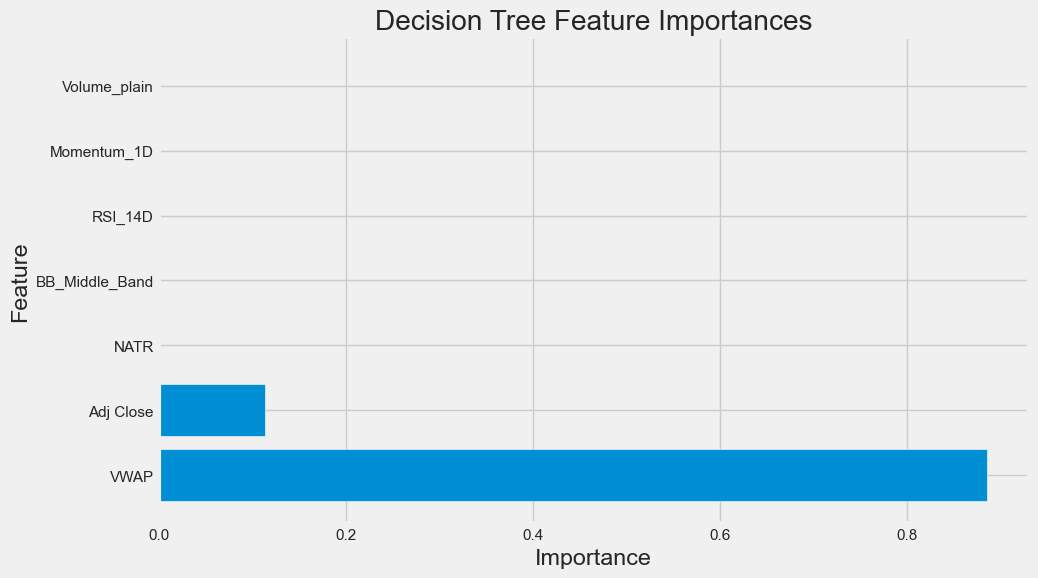

In [218]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor(random_state=5)
clf_dt = clf.fit(X_train, y_train)
validate_result(clf_dt, 'Decision Tree Regression')
feature_importances = clf.feature_importances_
# Get the names of the features
feature_names = list(fc)  # Assuming you have column names

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Decision Tree Feature Importances')
plt.show()


In [219]:
df['VwapC'] = (df['VWAP']*0.01+df['Close']*0.99)
df

,Open,High,Low,Close,Adj Close,Volume,Momentum_1D,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,VWAP,HL,absHC,absLC,TR,ATR,NATR,VwapC
Date,,,,,,,,,,,,,,,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.449691,302220800,0.000000,0.000000,302220800,0.000,0.000,0.000,14.669643,0.125000,0.000000,0.000000,0.125000,0.000000,0.000000,14.686614
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.516597,260022000,0.078928,0.000000,260022000,0.000,0.000,0.000,14.689959,0.192858,0.123215,0.069643,0.192858,0.000000,0.000000,14.764956
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.655551,271269600,0.163929,0.000000,271269600,0.000,0.000,0.000,14.739836,0.210000,0.182500,0.027500,0.210000,0.000000,0.000000,14.927745
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.787855,318292800,0.156072,0.000000,318292800,0.000,0.000,0.000,14.821452,0.126071,0.168571,0.042500,0.168571,0.000000,0.000000,15.083072
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.767570,394024400,-0.023929,0.000000,394024400,0.000,0.000,0.000,14.908383,0.228572,0.191072,0.037500,0.228572,0.000000,0.000000,15.060252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-06,176.380005,179.429993,176.210007,179.229996,178.994186,63841300,2.580002,46.889845,63841300,174.947,178.970,170.923,43.341207,3.219986,2.779999,0.439987,3.219986,3.298572,1.840413,177.871108
2023-11-07,179.179993,182.440002,178.970001,181.820007,181.580780,70530000,2.590012,46.640528,70530000,175.118,179.363,170.873,43.358015,3.470001,3.210007,0.259995,3.470001,3.370001,1.853482,180.435387
2023-11-08,182.350006,183.449997,181.589996,182.889999,182.649368,49340300,1.069992,41.028019,49340300,175.273,179.747,170.798,43.369925,1.860001,1.629990,0.230011,1.860001,3.313572,1.811784,181.494799


In [223]:

data = df.filter(['VwapC'])
dataset = data.values
dataset
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
model.fit(x_train, y_train, batch_size=1, epochs=1)
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions2 = model.predict(x_test)
predictions2 = scaler.inverse_transform(predictions2)

rmse2 = np.sqrt(np.mean(((predictions2 - y_test) ** 2)))
rmse2

[array([0.00376896, 0.00420201, 0.00510187, 0.00596049, 0.00583434,
       0.00613125, 0.00599697, 0.00577066, 0.00546199, 0.00641871,
       0.00728219, 0.00701778, 0.0055623 , 0.00695257, 0.00558463,
       0.01072461, 0.01033001, 0.01084975, 0.01197211, 0.01265323,
       0.01259851, 0.01239056, 0.01328366, 0.01412387, 0.01507623,
       0.016614  , 0.01984633, 0.01990144, 0.02170093, 0.02304641,
       0.02075652, 0.02164905, 0.02163474, 0.02412662, 0.02377589,
       0.02443405, 0.02561335, 0.02627158, 0.02816175, 0.02954285,
       0.0299444 , 0.03008608, 0.0277413 , 0.02717774, 0.02726515,
       0.02947607, 0.03009972, 0.03143675, 0.03458761, 0.03879622,
       0.03801858, 0.0380255 , 0.04106663, 0.04202169, 0.0413496 ,
       0.04073564, 0.04009499, 0.0422345 , 0.04370396, 0.04432159])]
[0.04280827686991147]

[array([0.00376896, 0.00420201, 0.00510187, 0.00596049, 0.00583434,
       0.00613125, 0.00599697, 0.00577066, 0.00546199, 0.00641871,
       0.00728219, 0.00701778, 0.00

2.5240037711839065

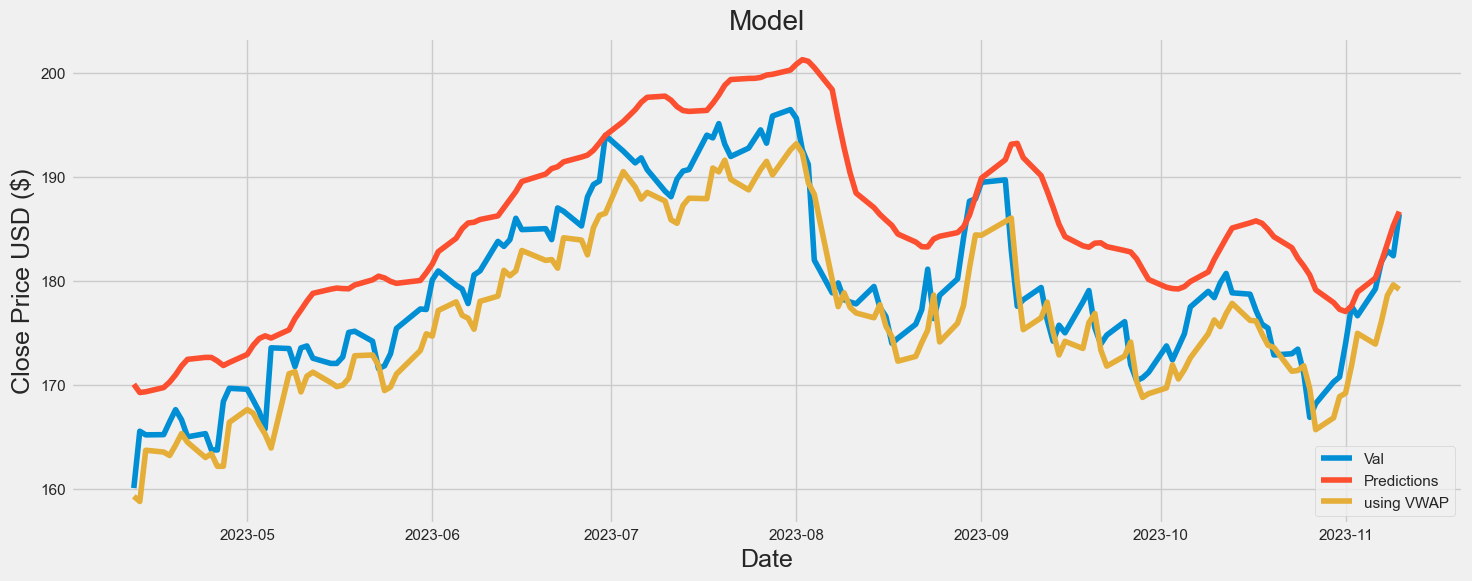

In [224]:
# Plot the data

valid['Prediction2'] = predictions2


# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(valid[['Close', 'Predictions','Prediction2']])
plt.legend(['Val', 'Predictions','using VWAP'], loc='lower right')
plt.show()

# Improvement


In [225]:
improvement_percentage = ((rmse - rmse2) / rmse) * 100

print(f"Improvement Percentage: {improvement_percentage:.2f}%")

Improvement Percentage: 65.36%


In [226]:
df

,Open,High,Low,Close,Adj Close,Volume,Momentum_1D,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,VWAP,HL,absHC,absLC,TR,ATR,NATR,VwapC
Date,,,,,,,,,,,,,,,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.449691,302220800,0.000000,0.000000,302220800,0.000,0.000,0.000,14.669643,0.125000,0.000000,0.000000,0.125000,0.000000,0.000000,14.686614
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.516597,260022000,0.078928,0.000000,260022000,0.000,0.000,0.000,14.689959,0.192858,0.123215,0.069643,0.192858,0.000000,0.000000,14.764956
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.655551,271269600,0.163929,0.000000,271269600,0.000,0.000,0.000,14.739836,0.210000,0.182500,0.027500,0.210000,0.000000,0.000000,14.927745
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.787855,318292800,0.156072,0.000000,318292800,0.000,0.000,0.000,14.821452,0.126071,0.168571,0.042500,0.168571,0.000000,0.000000,15.083072
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.767570,394024400,-0.023929,0.000000,394024400,0.000,0.000,0.000,14.908383,0.228572,0.191072,0.037500,0.228572,0.000000,0.000000,15.060252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-06,176.380005,179.429993,176.210007,179.229996,178.994186,63841300,2.580002,46.889845,63841300,174.947,178.970,170.923,43.341207,3.219986,2.779999,0.439987,3.219986,3.298572,1.840413,177.871108
2023-11-07,179.179993,182.440002,178.970001,181.820007,181.580780,70530000,2.590012,46.640528,70530000,175.118,179.363,170.873,43.358015,3.470001,3.210007,0.259995,3.470001,3.370001,1.853482,180.435387
2023-11-08,182.350006,183.449997,181.589996,182.889999,182.649368,49340300,1.069992,41.028019,49340300,175.273,179.747,170.798,43.369925,1.860001,1.629990,0.230011,1.860001,3.313572,1.811784,181.494799
